# **Preprocessing and Feature Selection of scRNA-Seq Data**

We first need to import relevant modules.

In [1]:
import numpy as np
import pandas as pd
import nvr
import matplotlib.pyplot as plt
%matplotlib inline

Next, upload UMI/counts from the data directory into a pandas Dataframe. This data is from mouse colon and has been reduced for computational time purposes, but steps outlined will be the same for full data sets.

In [2]:
counts = pd.read_csv( "/home/herrinca/workspace/Discovery_Oriented_Data_Science/Discovery_Oriented_Data_Science/data/raw_scRNA.csv")

Its always a good idea to check that your data has been loaded correctly.

In [3]:
counts.head()

,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012D04Rik,...,n-R5s90,n-R5s92,n-R5s93,n-R5s94,n-R5s95,n-R5s96,n-R5s97,n-R5s98,n-TSaga9,n-TStga1
0,0,4,4,0,0,0,1,0,3,0,...,0,0,0,0,0,0,0,0,0,0
1,0,8,1,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,4,3,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
num_cells, num_genes = counts.shape
print( "Number of cells = {0}...........Number of genes = {1}".format( num_cells, num_genes))

Number of cells = 3000...........Number of genes = 38487


## **Filter Cells Based on Library Size**

Retrieve gene names for filtering

Calculate the library size (total number of counts) for all cells and sort the sizes from highest to lowest.

In [29]:
lib_sizes = np.sort( np.sum( counts.values, axis=1))[::-1] # [::-1] reverses the array order so that its highest to lowest

A histogram of library sizes shows that most of these cells have very few gene counts, so we to remove the cells with very few counts.

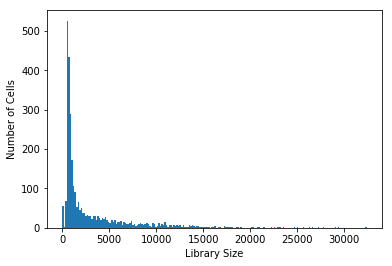

In [40]:
plt.hist( lib_sizes, bins=200)
plt.ylabel('Number of Cells')
_ = plt.xlabel('Library Size')

There are a few ways to accomplish this, but we prefer cumulative sum plotting. We start by first plotting the cumulative sum of the sorted cell library sizes, where cumulative sum of an *`array(a,b,c)`* equals *`(a, a+b, a+b+c)`*. We sorted or library sizes highest to lowest, so in our case *`a>b>c`*.

In [42]:
np.cumsum( [6,4,1])

array([ 6, 10, 11])

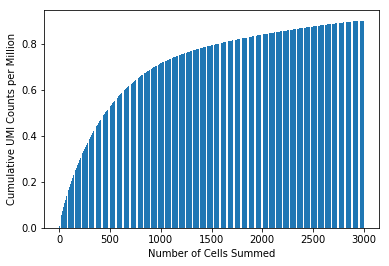

In [30]:
plt.bar( np.arange( num_cells), np.cumsum( lib_sizes)/1e7)
plt.ylabel( 'Cumulative UMI Counts per Million')
_ = plt.xlabel( 'Number of Cells Summed')

Cells with smaller library sizes will contribute less to the cumulative sum than cells with larger library sizes. Cells after the inflection point are considered "bad" due to their small library sizes. This cutoff changes dataset to dataset depending upon the platform, sequencing dept, biology, and etc.

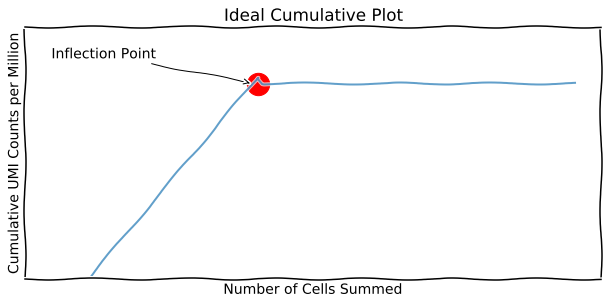

In [11]:
with plt.xkcd():
    fig = plt.figure( figsize=(10,5))
    ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    plt.xticks([])
    plt.yticks([])
    ax.set_ylim([-30, 10])
    data = np.ones(100) 
    data[:40] -= np.arange(40)[::-1] - 1
    plt.annotate( 'Inflection Point', xy=(38, 1), arrowprops=dict(arrowstyle='->'), xytext=(-0, 5))
    plt.plot(data, alpha=0.7)
    plt.scatter( 39, 1, c='red', s=500)
    plt.xlabel('Number of Cells Summed')
    plt.ylabel('Cumulative UMI Counts per Million')
    plt.title('Ideal Cumulative Plot')

Yes, this is very much a subjectively set threshold. For that reason, we like to under estimate the inflection point to be more restrictive. Here, we estimate it to be ~900

In [9]:
inflect_pt = 900

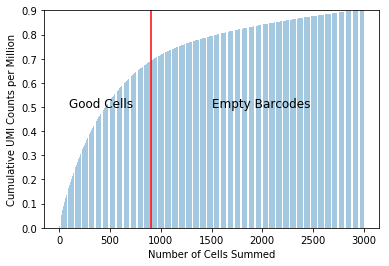

In [18]:
plt.bar( np.arange( num_cells), np.cumsum( lib_sizes)/1e7, alpha=0.4)
plt.vlines( inflect_pt, 0, 0.9, colors='red')
plt.ylabel( 'Cumulative UMI Counts per Million')
plt.text( 100, 0.5, 'Good Cells', fontsize=12)
plt.text( 1500, 0.5, 'Empty Barcodes', fontsize=12)
plt.ylim(0.0,0.9)
_ = plt.xlabel( 'Number of Cells Summed')

Good cells can now be selected for using our threshold. Since the library sizes were sorted from high to low we can pull the 900 cells with largest cell libraries using the `np.argsort()` function. Instead of returning the sorted values, `np.argsort()` returns an array of element indices that have been sorted on  values from lowest to highest.  

In [20]:
np.argsort( [5,1,2])

array([1, 2, 0])

In [25]:
np.argsort( lib_sizes)

array([2999, 2998, 2997, ...,    2,    1,    0])

Sort functions rank from lowest to highest so we want the last 900 cell indices.

In [28]:
good_ind = np.argsort( lib_sizes)[-inflect_pt:]

Select good cells from raw count data. 

In [32]:
good_cells = counts.iloc[good_ind,:]
good_cells.head()

,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012D04Rik,...,n-R5s90,n-R5s92,n-R5s93,n-R5s94,n-R5s95,n-R5s96,n-R5s97,n-R5s98,n-TSaga9,n-TStga1
899,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
898,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
897,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
896,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
895,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
good_cells.shape

(900, 38487)

In [5]:
genes = counts.columns

In [7]:
mt_mask = pd.Series( genes).str.startswith( 'mt').values
genes.values[mt_mask]

array(['mt-Atp6', 'mt-Atp8', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb',
       'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4', 'mt-Nd4l', 'mt-Nd5',
       'mt-Nd6', 'mt-Rnr1', 'mt-Rnr2', 'mt-Ta', 'mt-Tc', 'mt-Td', 'mt-Te',
       'mt-Tf', 'mt-Tg', 'mt-Th', 'mt-Ti', 'mt-Tk', 'mt-Tl1', 'mt-Tl2',
       'mt-Tm', 'mt-Tn', 'mt-Tp', 'mt-Tq', 'mt-Tr', 'mt-Ts1', 'mt-Ts2',
       'mt-Tt', 'mt-Tv', 'mt-Tw', 'mt-Ty'], dtype=object)

<BarContainer object of 3000 artists>

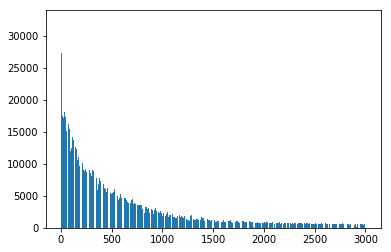

In [20]:
plt.bar( np.arange( num_cells), np.cumsum( counts.values, axis=1)[:,-1])

In [25]:
np.cumsum( [5,3,1])

array([5, 8, 9])

In [23]:
reduced.to_csv( "/home/herrinca/workspace/Discovery_Oriented_Data_Science/Discovery_Oriented_Data_Science/data/raw_scRNA_reduced.csv", index=None)